In [1]:
# all imports
from IPython.display import HTML
import numpy as np
import urllib2
import bs4 # beautiful soup
import time
import operator
import socket
import cPickle
import re # regular expressions

from pandas import Series
import pandas as pd
from pandas import DataFrame

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

## Cinemalytics

## Getting data with an API

In [2]:
%run scripts/cinemalytics.py

In [3]:
# libraries required
import json
import requests

auth_token = get_cinemalytics_auth_token()

url = 'http://api.cinemalytics.com/v1/movie/year/1990/?auth_token='+ auth_token
data = urllib2.urlopen(url).read()

In [4]:
# create array from JSON
dataArr = json.loads(data)

In [6]:
# explore array
print dataArr[0].keys()

[u'PosterPath', u'Rating', u'ReleaseDate', u'Description', u'Title', u'ImdbId', u'Region', u'RatingCount', u'Budget', u'Revenue', u'OriginalTitle', u'Country', u'Genre', u'CensorRating', u'Runtime', u'Id']


In [8]:
# count of results -> number of movies released in the year 1990
print len(dataArr)

24


In [9]:
# since this api gives us the all the movies released for a particular year we could
# build a database for the past two and half decades to see how the film industry have
# changed since then.

MOVIES_BY_YEAR_URL = 'http://api.cinemalytics.com/v1/movie/year/'
bollywood_movies_database = []

def build_movie_database(yearList):
    for year in yearList:
        url = MOVIES_BY_YEAR_URL + str(year) + '/?auth_token=' + auth_token
        
        movies_by_curr_year = urllib2.urlopen(url).read()
        movies_by_curr_year_list = json.loads(movies_by_curr_year)
        
        for m in movies_by_curr_year_list:
            bollywood_movies_database.append(m)
        
        time.sleep(2) # just being nice

In [10]:
yearList = range(1990, 2016) # from 1990 to 2015
build_movie_database(yearList)

In [11]:
movies = DataFrame(bollywood_movies_database)

In [12]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1730 entries, 0 to 1729
Data columns (total 16 columns):
Budget           1730 non-null int64
CensorRating     1730 non-null object
Country          1730 non-null object
Description      1730 non-null object
Genre            1730 non-null object
Id               1730 non-null object
ImdbId           1730 non-null object
OriginalTitle    1730 non-null object
PosterPath       1730 non-null object
Rating           1730 non-null float64
RatingCount      1730 non-null int64
Region           1730 non-null object
ReleaseDate      1730 non-null object
Revenue          1730 non-null int64
Runtime          1730 non-null int64
Title            1730 non-null object
dtypes: float64(1), int64(4), object(11)
memory usage: 229.8+ KB


## Saving data

In [15]:
movies.to_csv('./data/data.csv', index=False, encoding='utf-8')

In [16]:
## We have data for 1730 movies
## looks like censor rating is interpreted as an object so we have to take care of that
## lets take a look at data

movies.head()

,Budget,CensorRating,Country,Description,Genre,Id,ImdbId,OriginalTitle,PosterPath,Rating,RatingCount,Region,ReleaseDate,Revenue,Runtime,Title
0,0,,IN,,,6e94d6ec,tt0246008,Kondaveeti Donga,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,3/9/1990,0,0,Kondaveeti Donga
1,0,,IN,,,c5d72e04,tt0259877,Bandh Darwaza,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,6/1/1990,0,0,Bandh Darwaza
2,0,,IN,,,c228b5f0,tt0337650,Jawani Zindabad,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,7/17/1990,0,0,Jawani Zindabad
3,0,,IN,,,d57f08bc,tt0099080,Baaghi: A Rebel for Love,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,12/11/1990,0,0,Baaghi: A Rebel for Love
4,0,,IN,,,377bbe75,tt0242509,Haatim Tai,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,4/20/1990,0,125,Haatim Tai


In [17]:
# so most of the movies don't have censor rating
# let's get rid of it

movies.drop('CensorRating', inplace=True, axis=1)

In [18]:
# lets lowercase all the columns
movies.columns = movies.columns.map(lambda x: x.lower())

In [19]:
print list(movies.columns)

[u'budget', u'country', u'description', u'genre', u'id', u'imdbid', u'originaltitle', u'posterpath', u'rating', u'ratingcount', u'region', u'releasedate', u'revenue', u'runtime', u'title']


In [20]:
# release date has also been interpreted as an object
# lets convert it to datetime instead
movies.loc[:, 'releasedate'] = pd.to_datetime(movies.releasedate)

In [21]:
# lets take a look at the data again
movies.head()

,budget,country,description,genre,id,imdbid,originaltitle,posterpath,rating,ratingcount,region,releasedate,revenue,runtime,title
0,0,IN,,,6e94d6ec,tt0246008,Kondaveeti Donga,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,1990-03-09,0,0,Kondaveeti Donga
1,0,IN,,,c5d72e04,tt0259877,Bandh Darwaza,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,1990-06-01,0,0,Bandh Darwaza
2,0,IN,,,c228b5f0,tt0337650,Jawani Zindabad,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,1990-07-17,0,0,Jawani Zindabad
3,0,IN,,,d57f08bc,tt0099080,Baaghi: A Rebel for Love,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,1990-12-11,0,0,Baaghi: A Rebel for Love
4,0,IN,,,377bbe75,tt0242509,Haatim Tai,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,1990-04-20,0,125,Haatim Tai


In [22]:
# lets set the id as the index of the data frame
movies = movies.set_index('id')

In [23]:
movies.head()

,budget,country,description,genre,imdbid,originaltitle,posterpath,rating,ratingcount,region,releasedate,revenue,runtime,title
id,,,,,,,,,,,,,,
6e94d6ec,0,IN,,,tt0246008,Kondaveeti Donga,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,1990-03-09,0,0,Kondaveeti Donga
c5d72e04,0,IN,,,tt0259877,Bandh Darwaza,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,1990-06-01,0,0,Bandh Darwaza
c228b5f0,0,IN,,,tt0337650,Jawani Zindabad,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,1990-07-17,0,0,Jawani Zindabad
d57f08bc,0,IN,,,tt0099080,Baaghi: A Rebel for Love,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,1990-12-11,0,0,Baaghi: A Rebel for Love
377bbe75,0,IN,,,tt0242509,Haatim Tai,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,1990-04-20,0,125,Haatim Tai


## Analysis

** What are the 25 most rated movies ? **

In [24]:
most_rated = movies.sort(columns='ratingcount', ascending=False)[:25].originaltitle
most_rated

id
e80b298d    Kabhi Khushi Kabhie Gham
8a734920                          PK
7244b552             My Name Is Khan
102eb9f1      Hum Dil De Chuke Sanam
c945692d                   Shamitabh
0e8b2552                    Rockstar
8e7d7d14              Chak de Phatte
9848567b                      Ra.One
7a06c70c          Always Kabhi Kabhi
819042b0                  Dhobi Ghat
5dc67561           Shakti: The Power
6a82c73f     Bbuddah Hoga Terra Baap
efecebda      Hum Tumhare Hain Sanam
db6457e6                      Devdas
dcc7c8eb                    Saathiya
1d9473ca       Hum Kisi Se Kum Nahin
24bb9fc4                 Agni Varsha
4e7d6459                   Aarakshan
cd936015        Mujhse Dosti Karoge!
e76c2b7f                  F.A.L.T.U.
4de8768c                     Aankhen
dafb3923       Jeena Sirf Merre Liye
9d4dfbad           Dil Vil Pyar Vyar
a15cd99f                        Raaz
590f2a40            Dil Hai Tumhaara
Name: originaltitle, dtype: object

** Which movies are highly rated ? **

In [25]:
movies_stats = movies.sort(columns='rating', ascending=False)
movies_stats[['originaltitle','rating', 'ratingcount']].head()

,originaltitle,rating,ratingcount
id,,,
92ebv8cg,Baahubali: The Beginning,4.5000,1000
e80b298d,Kabhi Khushi Kabhie Gham,4.3000,1003
31ecbe29,Chak De! India,4.2000,1000
f0372714,Bhaag Milkha Bhaag,4.2000,1000
8a734920,PK,4.1517,1002


In [26]:
movies_stats[['originaltitle','rating', 'ratingcount']].tail()

,originaltitle,rating,ratingcount
id,,,
7dfa7e3c,Aanai,0,1
3f6fe5fa,Mumbai Express,0,1
01633b19,Barsaat: A Sublime Love Story,0,1
7c41b536,Jai Chiranjeeva,0,1
19cc5620,வேல்,0,1


In [27]:
# so there are many movies which are rated so rarely.

** Genre of top 50 most rated movies **

In [28]:
movies_stats[['originaltitle','genre','rating', 'ratingcount']].head(50)

,originaltitle,genre,rating,ratingcount
id,,,,
92ebv8cg,Baahubali: The Beginning,,4.5000,1000
e80b298d,Kabhi Khushi Kabhie Gham,Family,4.3000,1003
31ecbe29,Chak De! India,,4.2000,1000
f0372714,Bhaag Milkha Bhaag,,4.2000,1000
8a734920,PK,,4.1517,1002
f0884eea,Kabhi Haan Kabhi Naa,,4.1500,1000
cfaacb28,Swades,,4.1500,1000
aa2f3825,Black,,4.1500,1000
c89fb5d8,Dilwale Dulhania Le Jayenge,,4.1500,1000


### Many of the top rated movies are missing information for genre. Many of the top rated movies have a suspiciously same rating count of 1000, maybe it is capped  for some reasons ?

** Relationship between ratings and budget **

In [29]:
# noticed that there are many movies with budget value reported to be 0
# lets remove those movies

budget_non_zero = movies[movies.budget > 0]

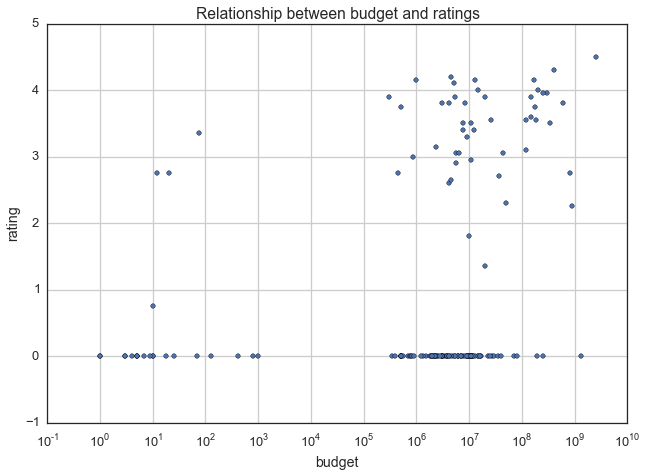

In [30]:
budget_non_zero.plot(x='budget', y='rating', kind='scatter', 
                     title='Relationship between budget and ratings',logx=True);

** Surprisingly there are many movies that score zero rating despite having huge budget, let's take a look at them **

In [31]:
big_flops = movies[(movies.budget > 0) & (movies.rating == 0)]

In [32]:
big_flops.head()

,budget,country,description,genre,imdbid,originaltitle,posterpath,rating,ratingcount,region,releasedate,revenue,runtime,title
id,,,,,,,,,,,,,,
7f9c2443,27000000,IN,,,tt0103976,City of Joy,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,1992-04-15,14683921,132,City of Joy
a6ba7e09,70,IN,,,tt0111742,Wolf,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,1994-06-17,131,125,Wolf
6052f948,11000000,IN,,,tt0114113,The Perez Family,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,1995-05-12,2832826,113,The Perez Family
a2f05ec6,3000000,IN,,,tt0116743,Kama Sutra - A Tale of Love,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,1996-09-11,4109095,117,Kama Sutra - A Tale of Love
750dc0cf,30000000,IN,,,tt0127536,Elizabeth,https://s3-ap-southeast-1.amazonaws.com/cinema...,0,1,BOLLYWOOD,1998-09-13,82102070,124,Elizabeth


** They have bad rating because not many people rated them **

In [33]:
# ok so lets take a look at those movies which have been rated atleast 100 times.
atleast_100 = movies[movies.ratingcount > 100]

In [34]:
atleast_100_budget_non_zero = atleast_100[atleast_100.budget > 0]

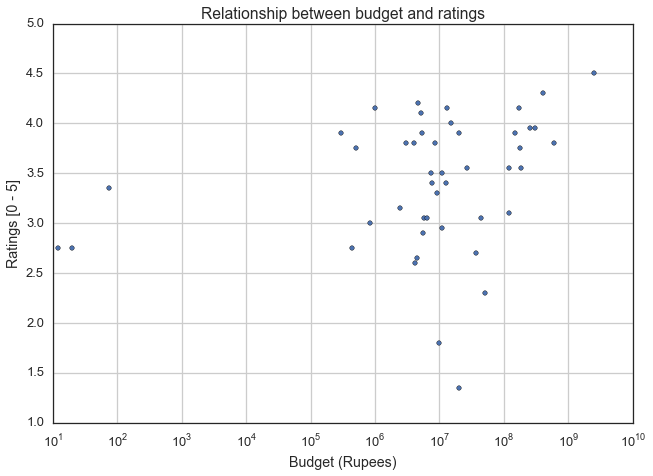

In [35]:
# let's revisit our question of how budget affects ratings ?
atleast_100_budget_non_zero.plot(x='budget', y='rating', kind='scatter',
                 title='Relationship between budget and ratings', logx=True)
plt.xlabel('Budget (Rupees)')
plt.ylabel('Ratings [0 - 5]');

** So as we can see budget and rating have a kind of linear relationship, if you throw big money your ratings will soar, but there are certain outliers, there are movies with decent ratings and a low enough budget and there are movies with very low ratings and an enormous budget, let's look into that **

In [38]:
mask = ((atleast_100_budget_non_zero.budget < 1e2) & (atleast_100_budget_non_zero.rating > 2))
quite_a_success = atleast_100_budget_non_zero[mask]

In [39]:
quite_a_success.head()

,budget,country,description,genre,imdbid,originaltitle,posterpath,rating,ratingcount,region,releasedate,revenue,runtime,title
id,,,,,,,,,,,,,,
0cae8726,75,IN,"in Mumbai, India, beautiful middle-class Jhanv...",,tt1084972,Wanted,https://s3-ap-southeast-1.amazonaws.com/cinema...,3.35,1000,BOLLYWOOD,2009-09-18,134,0,Wanted
9b0d979f,12,IN,A series of cover-ups and comic situations occ...,Action,tt1728986,Bol Bachchan,https://s3-ap-southeast-1.amazonaws.com/cinema...,2.75,1000,BOLLYWOOD,2012-07-06,17,155,Bol Bachchan
0de1888f,20,IN,Six would-be thieves enter a prestigious dance...,,tt2461132,Happy New Year,https://s3-ap-southeast-1.amazonaws.com/cinema...,2.75,1000,BOLLYWOOD,2014-10-23,53,180,Happy New Year


In [40]:
# Ah! the budget has not reported correctly for this movie, we need to see how to deal with this movie
# a) to remove it.
# b) correct the entry.
# c) derive some new statistic from it.

In [41]:
# To be specific there are three such movies for which the values of budget have not been reported properly

outliers = atleast_100_budget_non_zero[atleast_100_budget_non_zero.budget < 1e2]
outliers.head()

,budget,country,description,genre,imdbid,originaltitle,posterpath,rating,ratingcount,region,releasedate,revenue,runtime,title
id,,,,,,,,,,,,,,
0cae8726,75,IN,"in Mumbai, India, beautiful middle-class Jhanv...",,tt1084972,Wanted,https://s3-ap-southeast-1.amazonaws.com/cinema...,3.35,1000,BOLLYWOOD,2009-09-18,134,0,Wanted
9b0d979f,12,IN,A series of cover-ups and comic situations occ...,Action,tt1728986,Bol Bachchan,https://s3-ap-southeast-1.amazonaws.com/cinema...,2.75,1000,BOLLYWOOD,2012-07-06,17,155,Bol Bachchan
0de1888f,20,IN,Six would-be thieves enter a prestigious dance...,,tt2461132,Happy New Year,https://s3-ap-southeast-1.amazonaws.com/cinema...,2.75,1000,BOLLYWOOD,2014-10-23,53,180,Happy New Year


In [42]:
mask = ((atleast_100_budget_non_zero.budget > 1e5) & (atleast_100_budget_non_zero.rating < 3.0))
flops = atleast_100_budget_non_zero[mask]
flops

,budget,country,description,genre,imdbid,originaltitle,posterpath,rating,ratingcount,region,releasedate,revenue,runtime,title
id,,,,,,,,,,,,,,
1fb5c9f7,441892,IN,Prem (Salman Khan) likes to think he knows mor...,,tt0807758,Partner,https://s3-ap-southeast-1.amazonaws.com/cinema...,2.75,1000,BOLLYWOOD,2007-01-01,1030375,155,Partner
84bd9bc1,20000000,IN,A villain threatens the romance of a pair of t...,,tt0490170,Love Story 2050,https://s3-ap-southeast-1.amazonaws.com/cinema...,1.35,1000,BOLLYWOOD,2008-07-04,5000000,180,Love Story 2050
8df947ed,4180000,IN,"Sparks fly when Raj (Shahid Kapoor), a newly g...",,tt1105733,Kismat Konnection,https://s3-ap-southeast-1.amazonaws.com/cinema...,2.60,1000,BOLLYWOOD,2008-07-18,11000000,153,Kismat Konnection
c21cf9db,10000000,IN,"Three people (Salman Khan, Kareena Kapoor, Soh...",,tt1174041,Main Aurr Mrs. Khanna,https://s3-ap-southeast-1.amazonaws.com/cinema...,1.80,1000,BOLLYWOOD,2009-10-16,1850000,109,Main Aurr Mrs. Khanna
d7409b56,50000000,IN,The film opens with the family of archeologist...,,tt1227762,Aladin,https://s3-ap-southeast-1.amazonaws.com/cinema...,2.30,1000,BOLLYWOOD,2009-10-29,58200000,132,Aladin
6a8f69da,4500000,IN,Pinky Palkar (Deepika Padukone) is an aspiring...,Action,tt1606267,Lafangey Parindey,https://s3-ap-southeast-1.amazonaws.com/cinema...,2.65,1000,BOLLYWOOD,2010-08-20,5000000,126,Lafangey Parindey
3a884c91,5510000,IN,When Luv (Ali Zafar) has a bad break-up with h...,Action,tt1740710,Mere Brother Ki Dulhan,https://s3-ap-southeast-1.amazonaws.com/cinema...,2.90,1000,BOLLYWOOD,2011-09-09,18050000,0,Mere Brother Ki Dulhan
bb82c0d3,37000000,IN,A woman chooses one of three friends who all h...,,tt2229848,Chashme Baddoor,https://s3-ap-southeast-1.amazonaws.com/cinema...,2.70,1000,BOLLYWOOD,2013-04-05,5500000,0,Chashme Baddoor
536d0c1c,11000000,IN,A man's (Shahrukh Khan) trip to fulfill his la...,,tt2112124,Chennai Express,https://s3-ap-southeast-1.amazonaws.com/cinema...,2.95,1000,BOLLYWOOD,2013-08-09,60000000,141,Chennai Express


** Indeed these are some of the worst movies. **

## Relationship between runtime and ratings

In [43]:
# as earlier, we would again try to find subset of data 
# with non-zero runtime and rating values
runtimes_non_zero = movies[(movies.runtime > 0) & (movies.rating > 0)]

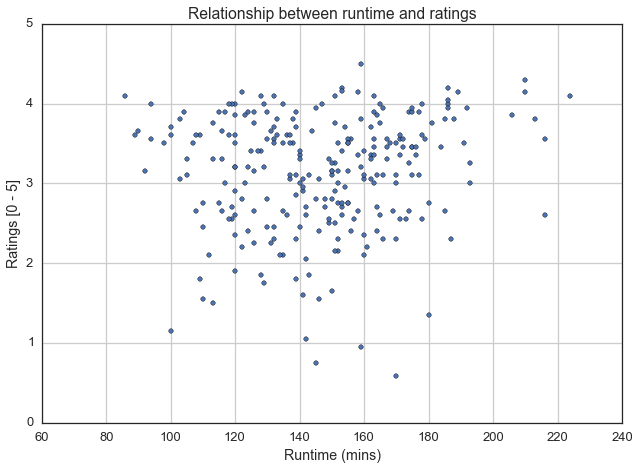

In [44]:
runtimes_non_zero.plot(x='runtime', y='rating', kind='scatter',
                       title='Relationship between runtime and ratings')
plt.xlabel('Runtime (mins)')
plt.ylabel('Ratings [0 - 5]');

In [45]:
runtimes_non_zero[['runtime', 'rating']].corr()

,runtime,rating
runtime,1.000000,0.111443
rating,0.111443,1.000000


** So the relationship here is far from being linear, there are many movies that run less than 100 minutes and still have very  high ratings and there are certain movies that have high ratings even though they run over 3 hours.**

In [46]:
mask = ((runtimes_non_zero.runtime < 100) & (runtimes_non_zero.rating > 3.0))
short_but_effective = runtimes_non_zero[mask]

In [47]:
short_but_effective.head()

,budget,country,description,genre,imdbid,originaltitle,posterpath,rating,ratingcount,region,releasedate,revenue,runtime,title
id,,,,,,,,,,,,,,
4886cff0,0,IN,Kiran Awasthi (Juhi Chawla) is engaged to Suni...,,tt0109556,Darr,https://s3-ap-southeast-1.amazonaws.com/cinema...,4.00,1000,BOLLYWOOD,1993-12-23,0,94,Darr
ca234902,0,IN,An estranged family finds redemption in the un...,,tt0295682,The Warrior,https://s3-ap-southeast-1.amazonaws.com/cinema...,4.10,1000,BOLLYWOOD,2001-09-23,0,86,The Warrior
9bed700d,0,IN,Swapner Din is a 2004 Bengali drama film direc...,,tt0424474,Swapner Din,https://s3-ap-southeast-1.amazonaws.com/cinema...,3.60,1000,BOLLYWOOD,2004-04-01,0,89,Swapner Din
67961f22,0,IN,"After a man's tragic death, his family casts o...",,tt0398390,White Rainbow,https://s3-ap-southeast-1.amazonaws.com/cinema...,3.55,1000,BOLLYWOOD,2005-03-03,0,94,White Rainbow
471e8836,0,IN,Being Cyrus is an English language Indian film...,,tt0412308,Being Cyrus,https://s3-ap-southeast-1.amazonaws.com/cinema...,3.65,1000,BOLLYWOOD,2006-03-24,0,90,Being Cyrus


In [48]:
mask = ((runtimes_non_zero.runtime > 180) & (runtimes_non_zero.rating > 3))
long_yet_effective = runtimes_non_zero[mask]

In [49]:
long_yet_effective.head()

,budget,country,description,genre,imdbid,originaltitle,posterpath,rating,ratingcount,region,releasedate,revenue,runtime,title
id,,,,,,,,,,,,,,
46f73436,0,IN,"Three brothers (Amitabh Bachchan, Govinda, Raj...",Action,tt0102071,Hum,https://s3-ap-southeast-1.amazonaws.com/cinema...,3.45,1000,BOLLYWOOD,1991-01-23,0,184,Hum
90b92bcf,0,IN,An Afghan warrior (Amitabh Bachchan) seeks fin...,Action,tt0104607,Khuda Gawah,https://s3-ap-southeast-1.amazonaws.com/cinema...,3.25,1000,BOLLYWOOD,1992-05-08,0,193,Khuda Gawah
1c20c038,0,IN,"Prem, a top student, is learning the ropes of ...",,tt0110076,Hum Aapke Hain Koun,https://s3-ap-southeast-1.amazonaws.com/cinema...,3.85,1000,BOLLYWOOD,1994-08-05,26900000,206,Hum Aapke Hain Koun
c89fb5d8,1000000,IN,Raj and Simran meet on a trip to Europe. After...,,tt0112870,Dilwale Dulhania Le Jayenge,https://s3-ap-southeast-1.amazonaws.com/cinema...,4.15,1000,BOLLYWOOD,1995-10-19,10320000,189,Dilwale Dulhania Le Jayenge
bc3b1c5f,0,IN,"Emotionally attached to his motherland, a U.S....",,tt0119861,Pardes,https://s3-ap-southeast-1.amazonaws.com/cinema...,3.50,1000,BOLLYWOOD,1997-01-01,0,191,Pardes


## Relationship between Release date and Ratings

** How ratings have changed over years ?**

In [51]:
ratings_non_zero  = movies[movies.rating > 0]
ratings_non_zero.loc[:, 'releasedecade'] = ratings_non_zero.releasedate.dt.year // 10 * 10
ratings_non_zero.loc[:, 'releaseyear'] = ratings_non_zero.releasedate.dt.year
ratings_non_zero.loc[:, 'releasemonth'] = ratings_non_zero.releasedate.dt.month

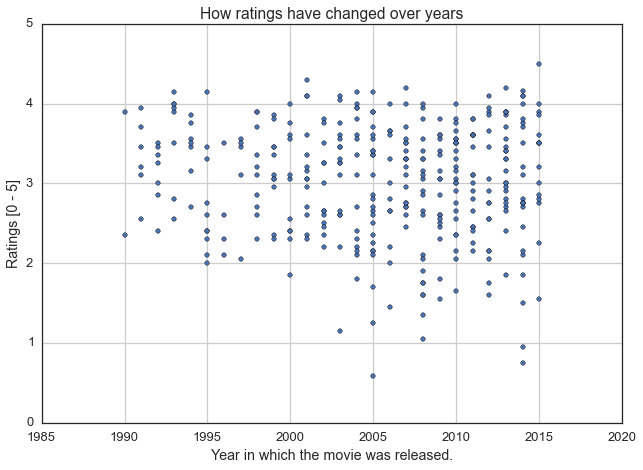

In [52]:
ratings_non_zero.plot(x='releaseyear', y='rating', kind='scatter',
                      title='How ratings have changed over years')
plt.xlabel('Year in which the movie was released.')
plt.ylabel('Ratings [0 - 5]');

** More and more movies are getting rated since 1990. **

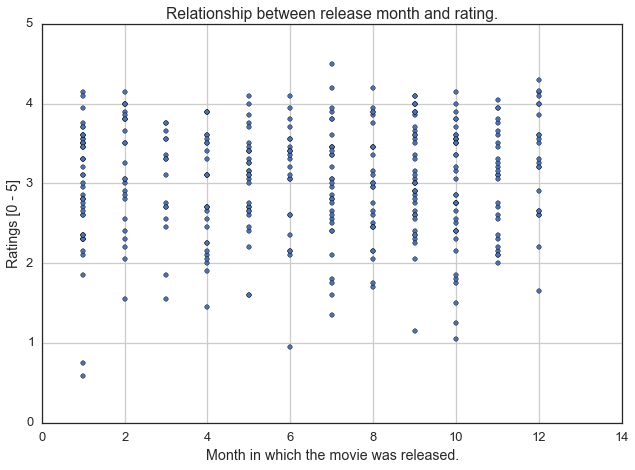

In [54]:
ratings_non_zero.plot(x='releasemonth', y='rating', kind='scatter',
                      title='How ratings have changed over years')
plt.xlabel('Month in which the movie was released.')
plt.ylabel('Ratings [0 - 5]')
plt.title('Relationship between release month and rating.');

In [55]:
movies_grouped_by_releasemonth = ratings_non_zero.groupby('releasemonth')
movies_grouped_by_releasemonth.size().order(ascending=False)

releasemonth
1               47
9               40
10              39
7               33
5               30
8               28
11              27
4               27
2               25
6               23
12              22
3               16
dtype: int64

** As you can see most of the movies were released in January ( New Year ) followed by September ( Eid ) **

In [56]:
movies_grouped_by_releasemonth.rating.mean()

releasemonth
1               2.959220
2               3.196000
3               2.990625
4               2.864815
5               3.040000
6               3.054357
7               2.980303
8               2.966071
9               3.116250
10              2.898718
11              3.024074
12              3.318259
Name: rating, dtype: float64

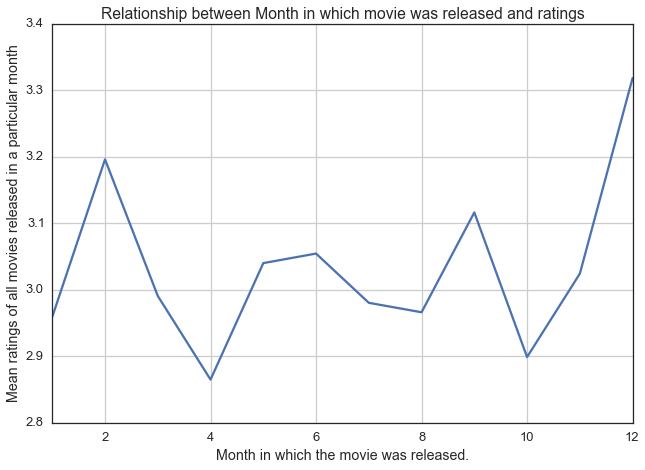

In [57]:
movies_grouped_by_releasemonth.rating.mean().plot()
plt.xlabel('Month in which the movie was released.')
plt.ylabel('Mean ratings of all movies released in a particular month')
plt.title('Relationship between Month in which movie was released and ratings');

** There seems to be a trend, movies that were released in first and last quarter generally have high ratings **

## Distribution of ratings

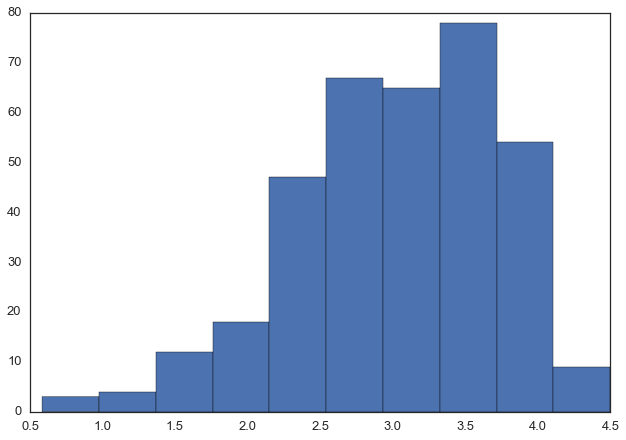

In [65]:
plt.hist(ratings_non_zero.rating);

In [67]:
ratings_non_zero_with_date_index = ratings_non_zero.set_index('releasedate')

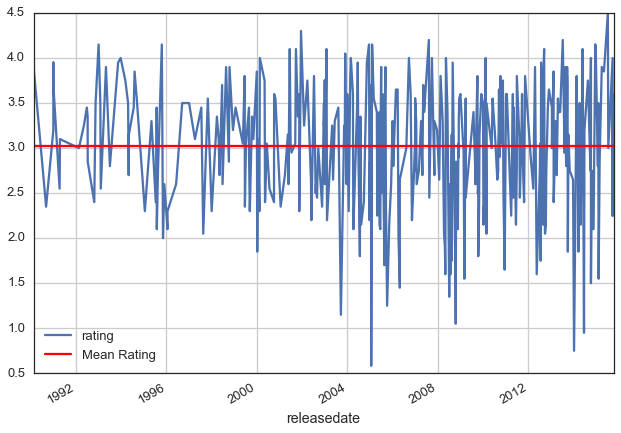

In [85]:
only_ratings = ratings_non_zero_with_date_index.rating
only_ratings.plot(kind='line');
plt.axhline(only_ratings.mean(), 0., 1., color='r', label='Mean Rating');
plt.legend(loc=0);

In [79]:
only_ratings.mean()

3.0234880476190482